# TV Series Analyzer

Visualize how a given TV Series is rated over time.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib
import seaborn as sns
from omdb import OMDBClient

sns.set()
client = OMDBClient(apikey='cc71ac81')
client.set_default('tomatoes', True)

%matplotlib inline

In [2]:
def get_info(title='Game of Thrones'):
    try:
        #check if we already have the ratings of the listing
        data = np.load('data/{}.npy'.format(title.lower()))
        print('Loaded data from disk')
        return data, title
    except:
        #ratings for season 1
        xml_content = client.get(title=title, season=1)
        num_episodes = len(xml_content['episodes'])

        #total number of seasons
        total_seasons = int(xml_content['total_seasons'])
        print("Total seasons: {}".format(total_seasons))

        list = []
        listoflists = []

        for item in xml_content['episodes']:
             list.append(item['imdb_rating'])
        listoflists.append(list)

        #get the ratings of other seasons
        for i in range(2, total_seasons+1):
            list = []
            xml_content = client.get(title=title, season=i)
            for item in xml_content['episodes']:
                list.append(item['imdb_rating'])
            listoflists.append(list)

        maxlen = 0
        for item in listoflists:
            if len(item) > maxlen:
                maxlen = len(item)

        for item in listoflists:
            while len(item) < maxlen:
                item.append(None)

        data = np.array(listoflists).transpose()
        np.place(data, data=='N/A', None)
        data = data.astype(np.float)
        print('Loaded data from omdb')
        np.save('data/{}'.format(title.lower()), data)
        return data, title

In [3]:
def get_colors(rating_data):
    cmap = matplotlib.cm.get_cmap('seismic')
    norm = matplotlib.colors.Normalize(vmin=np.nanmin(rating_data), vmax=np.nanmax(rating_data))

    colors = []
    for item in rating_data:
        for i in item:
            if not np.isnan(i):
                colors.append(col.to_hex(cmap(norm(i))))
            else:
                colors.append('#FFFFFF')
                
    return colors

In [4]:
def get_xy_labels(rating_data):
    #adding season (column) labels
    collabels = []
    i=1
    for item in rating_data[0]:
        collabels.append('Season {}'.format(i))
        i=i+1

    #episode (row) labels
    rowlabels = []
    i=1
    for item in rating_data:
        rowlabels.append('Episode {}'.format(i))
        i=i+1
        
    return collabels, rowlabels

In [5]:
def plot_matrix(rating_data, colors, title='Game of Thrones'):
    from matplotlib import rcParams
    rcParams.update({'figure.autolayout': True})

    fig = plt.figure(figsize=(rating_data.shape))
    ax = fig.add_subplot(1,1,1)
    
    collabels, rowlabels = get_xy_labels(rating_data)
    #plotting table
    table = plt.table(cellText=rating_data, 
              cellColours=np.array(colors).reshape(rating_data.shape),
              colLabels=collabels,
              rowLabels=rowlabels,
              loc='best'
         )
    

    #hide nans
    cells = table.get_celld()
    for i in range(rating_data.shape[0]+1):
        for j in range(rating_data.shape[1]):
            if cells[i, j].get_text().get_text() == 'nan':
                cells[i, j].set_visible(False)

    fig.suptitle(title, fontsize=50, y=1.08)
    table.set_fontsize(14)
    table.scale(1,4)
    plt.tight_layout()
    ax.axis('off')
    plt.savefig('static/{}_rating_matrix'.format(title), bbox_inches = "tight")

In [6]:
data, title = get_info()
colors = get_colors(data)

Loaded data from disk


In [7]:
def plot_rating_per_season(data):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1,1,1)
    
    mean_ratings_per_season = np.nanmean(data, axis=0)
    seasonlabels, episodelabels = get_xy_labels(data)
    
    sns.lineplot(seasonlabels, mean_ratings_per_season, markers=True)

    ax.set_ylabel('IMDB Rating')
    ax.set_title('Mean episode rating per season')

In [8]:
def plot_scattered_ratings_per_season(data):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1,1,1)
    
    seasonlabels, episodelabels = get_xy_labels(data)
    results = []
    for i in range(len(seasonlabels)):
        for j in range(len(data)):
            results.append((i, data[j, i]))

    results = pd.DataFrame(results)

    ax = sns.regplot(results[0], results[1], order=2)
    ax.set_xticks(np.arange(len(seasonlabels)))
    ax.set_xticklabels(seasonlabels)
    ax.set_ylabel('IMDB Score')
    ax.set_xlabel('')
    ax.set_title('Ratings per season')

![alt text](xml_content['poster'] "poster")

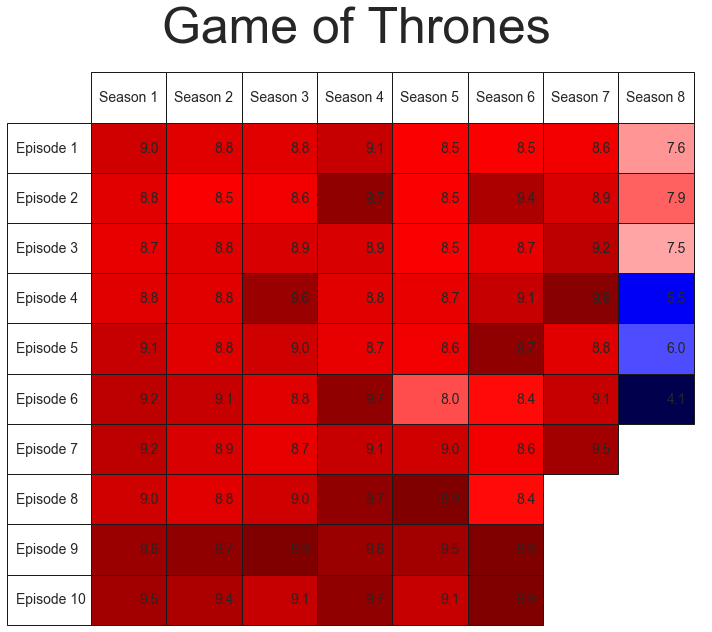

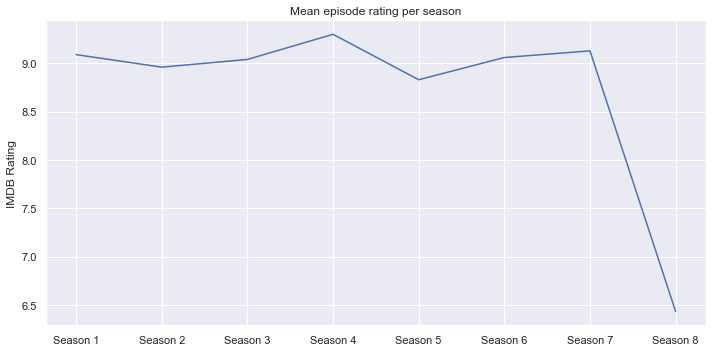

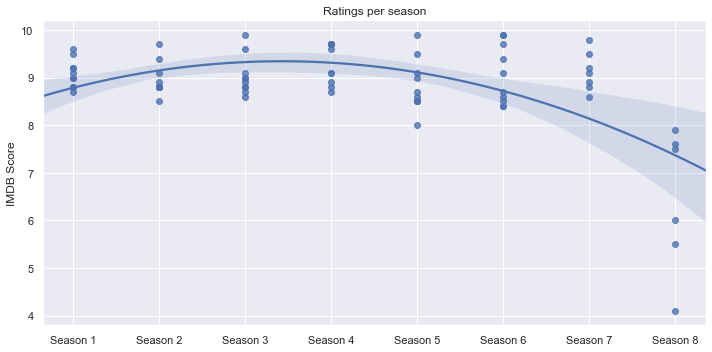

In [9]:
plot_matrix(data, colors, title=title)
plot_rating_per_season(data)
plot_scattered_ratings_per_season(data)

In [10]:
xml_content = client.get(title=title)

In [24]:
xml_content

{'title': 'Game of Thrones',
 'year': '2011–',
 'rated': 'TV-MA',
 'released': '17 Apr 2011',
 'runtime': '57 min',
 'genre': 'Action, Adventure, Drama, Fantasy, Romance',
 'director': 'N/A',
 'writer': 'David Benioff, D.B. Weiss',
 'actors': 'Peter Dinklage, Lena Headey, Emilia Clarke, Kit Harington',
 'plot': 'Nine noble families fight for control over the mythical lands of Westeros, while an ancient enemy returns after being dormant for thousands of years.',
 'language': 'English',
 'country': 'USA, UK',
 'awards': 'Won 1 Golden Globe. Another 273 wins & 454 nominations.',
 'poster': 'https://m.media-amazon.com/images/M/MV5BMjA5NzA5NjMwNl5BMl5BanBnXkFtZTgwNjg2OTk2NzM@._V1_SX300.jpg',
 'ratings': [{'source': 'Internet Movie Database', 'value': '9.5/10'}],
 'metascore': 'N/A',
 'imdb_rating': '9.5',
 'imdb_votes': '1,429,496',
 'imdb_id': 'tt0944947',
 'type': 'series',
 'total_seasons': '8',
 'tomato_meter': 'N/A',
 'tomato_image': 'N/A',
 'tomato_rating': 'N/A',
 'tomato_reviews': '

In [11]:
xml_content['title']

'Game of Thrones'

In [19]:
xml_content['year']

'2011–'

In [16]:
xml_content['imdb_rating']

'9.5'

In [18]:
xml_content['imdb_votes']

'1,429,496'

In [17]:
xml_content['plot']

'Nine noble families fight for control over the mythical lands of Westeros, while an ancient enemy returns after being dormant for thousands of years.'

In [23]:
for item in xml_content:
    print(item)
    print(xml_content[item])

title
Game of Thrones
year
2011–
rated
TV-MA
released
17 Apr 2011
runtime
57 min
genre
Action, Adventure, Drama, Fantasy, Romance
director
N/A
writer
David Benioff, D.B. Weiss
actors
Peter Dinklage, Lena Headey, Emilia Clarke, Kit Harington
plot
Nine noble families fight for control over the mythical lands of Westeros, while an ancient enemy returns after being dormant for thousands of years.
language
English
country
USA, UK
awards
Won 1 Golden Globe. Another 273 wins & 454 nominations.
poster
https://m.media-amazon.com/images/M/MV5BMjA5NzA5NjMwNl5BMl5BanBnXkFtZTgwNjg2OTk2NzM@._V1_SX300.jpg
ratings
[{'source': 'Internet Movie Database', 'value': '9.5/10'}]
metascore
N/A
imdb_rating
9.5
imdb_votes
1,429,496
imdb_id
tt0944947
type
series
total_seasons
8
tomato_meter
N/A
tomato_image
N/A
tomato_rating
N/A
tomato_reviews
N/A
tomato_fresh
N/A
tomato_rotten
N/A
tomato_consensus
N/A
tomato_user_meter
N/A
tomato_user_rating
N/A
tomato_user_reviews
N/A
tomato_url
N/A
dvd
N/A
box_office
N/A
prod

In [13]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get(xml_content['poster'])
img = Image.open(BytesIO(response.content))

In [29]:
img.save('static/{}.png'.format(title.lower()), format='png')

In [25]:
title

'Game of Thrones'